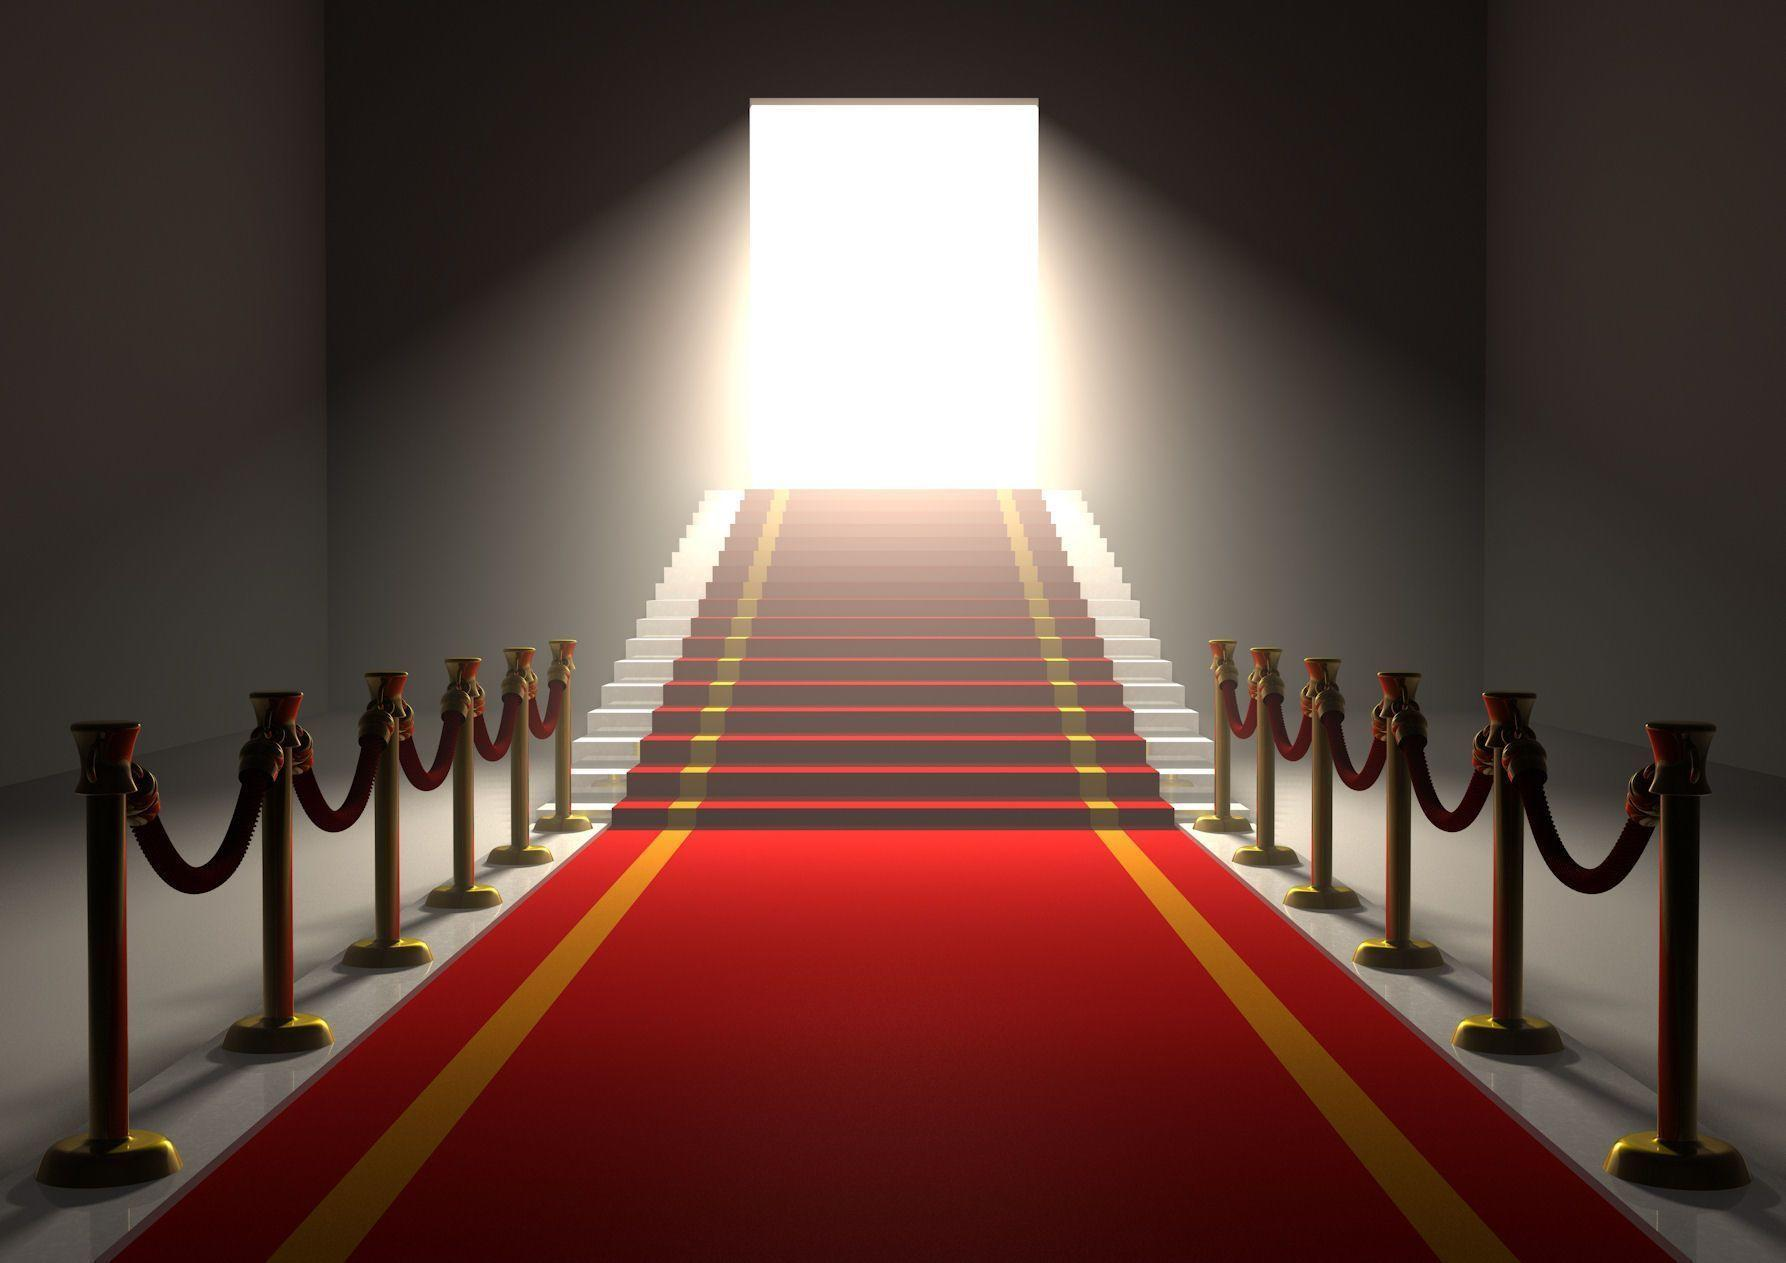

# The Art of the Blockbuster

**Author:** Jake Sherman
***

## Overview

While many typical Hollywood hits tend to be rather formulaic, producing the next big movie is anything but.  The problem with producing movies is the unpredictable nature of their profitability.  This notebook a analyzes production budget, genre, and film runtime to see if the art of the blockbuster is really more of a science. 

Findings show that low budget movies have the highest ROI on average, horror is the most profitable genre, and runtime is more of a dependent variable than profitability indicator.

## Business Problem

Producing a movie is extremely capital intensive and unlike traditional investments, a movie can bomb and leave investors with a total loss of investment in the blink of an eye.  There is extremely high volatility in performance relative to other investments, that is, often times movies are hit or miss.  This analysis aims to look at data, specifically relating to runtime, production budget, and film genre to see if there are ways a production company can focus its business plan to optimize profitability.

## Data Understanding

Data being used comes from a csv database containing information related to production budget and worldwide gross to determine the films ROI.  This dataframe was merged with a SQL database containing runtime and genre information. The target variable is ROI or return on investment which is calculated as ((worldwide theatrical gross / production budget -1)*100). The analysis looks at how ROI is affected by changes in runtime, genre, and production budget.

Alternatively, another dataframe was created that contained only data from films that were considered a 'success' by this analysis.  The requirement for 'success' was if a film returned double its production budget or achieved an ROI of 100%.  This method is more focused on reliability of performance and reduces emphasis on outlier returns.

In [1]:
#Importing relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import csv


%matplotlib inline

In [2]:
#Naming Data Files
box_office= pd.read_csv('zippedData/bom.movie_gross.csv.gz', compression= 'gzip')
movie_budgets= pd.read_csv('zippedData/tn.movie_budgets.csv.gz')
movie_info= pd.read_csv('zippedData/tmdb.movies.csv.gz')
dw= pd.read_csv('zippedData/rt.movie_info.tsv.gz', sep= '\t')
movie_reviews= pd.read_csv('zippedData/rt.reviews.tsv.gz', sep= '\t', encoding= 'unicode_escape')
#! unzip -n zippedData/im.db
conn = sqlite3.connect('zippedData/imdb.db')
cur = conn.cursor()
tables_query = '''SELECT name FROM sqlite_master WHERE type = 'table';'''
cur.execute(tables_query)
print(cur.fetchall())

[('movie_basics',), ('directors',), ('known_for',), ('movie_akas',), ('movie_ratings',), ('persons',), ('principals',), ('writers',)]


In [3]:
cur.execute('''SELECT primary_title, genres, runtime_minutes, start_year  FROM movie_basics;''')
cur.fetchall()

[('Sunghursh', 'Action,Crime,Drama', 175.0, 2013),
 ('One Day Before the Rainy Season', 'Biography,Drama', 114.0, 2019),
 ('The Other Side of the Wind', 'Drama', 122.0, 2018),
 ('Sabse Bada Sukh', 'Comedy,Drama', None, 2018),
 ('The Wandering Soap Opera', 'Comedy,Drama,Fantasy', 80.0, 2017),
 ('A Thin Life', 'Comedy', 75.0, 2018),
 ('Bigfoot', 'Horror,Thriller', None, 2017),
 ('Joe Finds Grace', 'Adventure,Animation,Comedy', 83.0, 2017),
 ('O Silêncio', 'Documentary,History', None, 2012),
 ('Nema aviona za Zagreb', 'Biography', 82.0, 2012),
 ('Pál Adrienn', 'Drama', 136.0, 2010),
 ('So Much for Justice!', 'History', 100.0, 2010),
 ('Cooper and Hemingway: The True Gen', 'Documentary', 180.0, 2013),
 ('Children of the Green Dragon', 'Drama', 89.0, 2010),
 ('T.G.M. - osvoboditel', 'Documentary', 60.0, 2018),
 ('The Tragedy of Man', 'Animation,Drama,History', 160.0, 2011),
 ("How Huang Fei-hong Rescued the Orphan from the Tiger's Den",
  None,
  None,
  2011),
 ('Heaven & Hell', 'Drama', 1

## Data Preparation

The IMDB SQLdatabase only contains information on films dating back to 2010 so all films prior to 2010 were dropped in order to conduct the genre and runtime analysis. Entries with no runtime or genre were also dropped.

Film festivals also only recognize an entry as a feature film if it is at least 75 minutes long so all entries shorter were dropped.

Each film was associated with three genres.  This analysis dropped the secondary and tertiary genre to focus on the impact the primary genre has on ROI.

ROI column was added to the dataframe.

The study of production budget added back movies prior to 2010 as their runtime and genre were not required. However, some movies were self produced by film makers and/or had celebrity favors that allowed for a lower production budget than would otherwise be required- all entries below $1M production budget were dropped.

Although production budgets have a strong correlation to worldwide gross, there is no positive correlation to ROI.  As such production budgets were broken down into 4 tiers recognized in the industry:
        Low Budget Films: $0.5M-$5M
        Mid-Level Budget Films: $5M-$50M
        Big Budget Films: $50M-$100M
        Blockbuster Films: $100M+
Each tier is analyzed against ROI to determine the optimal production budget tier.

In [4]:
#Extract needed columns from SQL database
genre_df= pd.read_sql('''SELECT primary_title, genres, runtime_minutes, start_year FROM movie_basics;''', conn)
genre_df

,primary_title,genres,runtime_minutes,start_year
0,Sunghursh,"Action,Crime,Drama",175.0,2013
1,One Day Before the Rainy Season,"Biography,Drama",114.0,2019
2,The Other Side of the Wind,Drama,122.0,2018
3,Sabse Bada Sukh,"Comedy,Drama",NaN,2018
4,The Wandering Soap Opera,"Comedy,Drama,Fantasy",80.0,2017
...,...,...,...,...
146139,Kuambil Lagi Hatiku,Drama,123.0,2019
146140,Rodolpho Teóphilo - O Legado de um Pioneiro,Documentary,NaN,2015
146141,Dankyavar Danka,Comedy,NaN,2013
146142,6 Gunn,None,116.0,2017


In [5]:
print(genre_df.dtypes)
print(genre_df.shape)

primary_title       object
genres              object
runtime_minutes    float64
start_year           int64
dtype: object
(146144, 4)


In [6]:
genre_df = genre_df.sort_values(by= 'start_year', ascending=False)
genre_df.tail(50)
#Analysis of genre and movie runtime will date back as far 2010

,primary_title,genres,runtime_minutes,start_year
33645,The Hutou Fortress: Bacteria,War,NaN,2010
14446,Gesher,Drama,84.0,2010
14459,Leftovers,Comedy,96.0,2010
14458,Labranza oculta,"Animation,Documentary,Drama",66.0,2010
14456,Keepers of the Light,"Documentary,Drama,Family",85.0,2010
14455,Jimmy Tingle's American Dream,"Comedy,Documentary",70.0,2010
14453,Invisible Voices,"Documentary,Drama",93.0,2010
136617,Kreschtheater - Knapp dran vorbei,Documentary,45.0,2010
14452,I Am an Island,Drama,52.0,2010
14451,How to Make it in Filmmaking,"Biography,Documentary",57.0,2010


In [7]:
genre_df.sort_values(by='runtime_minutes').head(50)

,primary_title,genres,runtime_minutes,start_year
22903,Tierra,"Documentary,Family",1.0,2010
57140,Shark Sanctuary,"Adventure,Documentary",1.0,2012
114067,One Minute Of Resistance,"Documentary,News",1.0,2017
93214,Great Valley Nature Center Documentary,Documentary,1.0,2015
2570,Lamentation For Little Girls Who Are In Love W...,Animation,1.0,2019
116943,"Warnings missed? The crop circle of May 21, 2017","Documentary,Horror,Mystery",1.0,2017
125975,"parTy boi, black diamonds in ice castles",Documentary,1.0,2017
3298,Happy New Year,Animation,1.0,2019
95787,A Serendipitous Exploration,Documentary,1.0,2016
72190,Powered By Green Smoothies,"Adventure,Documentary,Sport",1.0,2014


In [8]:
#As this is a study of feature lengh films, we will drop all rows with runtime_minutes below 75
genre_df = genre_df.drop(genre_df[genre_df.runtime_minutes<75].index)

In [9]:
#Almost half the database was comprised of short films
genre_df.shape

(111705, 4)

In [10]:
#Extracting just the year from release date and then converting to int
movie_budgets['release_date']= movie_budgets['release_date'].map(lambda x: x[-4:])
movie_budgets['release_date']=movie_budgets['release_date'].astype(int)

In [11]:
movie_budgets.dtypes

id                    int64
release_date          int32
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [12]:
#Drop movies released before 2010 to match with SQL database
movie_budgets_2010= movie_budgets.drop(movie_budgets[movie_budgets.release_date<2010].index)

In [13]:
movie_budgets_2010.head(50)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
1,2,2011,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,2019,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,2015,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,2017,Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"
5,6,2015,Star Wars Ep. VII: The Force Awakens,"$306,000,000","$936,662,225","$2,053,311,220"
6,7,2018,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200"
8,9,2017,Justice League,"$300,000,000","$229,024,295","$655,945,209"
9,10,2015,Spectre,"$300,000,000","$200,074,175","$879,620,923"
10,11,2012,The Dark Knight Rises,"$275,000,000","$448,139,099","$1,084,439,099"
11,12,2018,Solo: A Star Wars Story,"$275,000,000","$213,767,512","$393,151,347"


In [14]:
#Merge dataframes to have genre, runtime_minutes, production_budget, and worldwide_gross on same dataframe
budgets_genres_df= movie_budgets_2010.merge(genre_df, left_on=('movie'), right_on=('primary_title'), how='inner')
budgets_genres_df.head(50)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,start_year
0,2,2011,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",136.0,2011
1,3,2019,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",Dark Phoenix,"Action,Adventure,Sci-Fi",113.0,2019
2,4,2015,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",141.0,2015
3,7,2018,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",Avengers: Infinity War,"Action,Adventure,Sci-Fi",149.0,2018
4,9,2017,Justice League,"$300,000,000","$229,024,295","$655,945,209",Justice League,"Action,Adventure,Fantasy",120.0,2017
5,10,2015,Spectre,"$300,000,000","$200,074,175","$879,620,923",Spectre,"Action,Adventure,Thriller",148.0,2015
6,11,2012,The Dark Knight Rises,"$275,000,000","$448,139,099","$1,084,439,099",The Dark Knight Rises,"Action,Thriller",164.0,2012
7,12,2018,Solo: A Star Wars Story,"$275,000,000","$213,767,512","$393,151,347",Solo: A Star Wars Story,"Action,Adventure,Fantasy",135.0,2018
8,13,2013,The Lone Ranger,"$275,000,000","$89,302,115","$260,002,115",The Lone Ranger,"Action,Adventure,Western",150.0,2013
9,14,2012,John Carter,"$275,000,000","$73,058,679","$282,778,100",John Carter,"Action,Adventure,Sci-Fi",132.0,2012


In [15]:
#Drop duplicate entries
budgets_genres_df=budgets_genres_df.drop_duplicates(subset= 'movie', keep='first')
budgets_genres_df.head(50)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,start_year
0,2,2011,Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",136.0,2011
1,3,2019,Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",Dark Phoenix,"Action,Adventure,Sci-Fi",113.0,2019
2,4,2015,Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",141.0,2015
3,7,2018,Avengers: Infinity War,"$300,000,000","$678,815,482","$2,048,134,200",Avengers: Infinity War,"Action,Adventure,Sci-Fi",149.0,2018
4,9,2017,Justice League,"$300,000,000","$229,024,295","$655,945,209",Justice League,"Action,Adventure,Fantasy",120.0,2017
5,10,2015,Spectre,"$300,000,000","$200,074,175","$879,620,923",Spectre,"Action,Adventure,Thriller",148.0,2015
6,11,2012,The Dark Knight Rises,"$275,000,000","$448,139,099","$1,084,439,099",The Dark Knight Rises,"Action,Thriller",164.0,2012
7,12,2018,Solo: A Star Wars Story,"$275,000,000","$213,767,512","$393,151,347",Solo: A Star Wars Story,"Action,Adventure,Fantasy",135.0,2018
8,13,2013,The Lone Ranger,"$275,000,000","$89,302,115","$260,002,115",The Lone Ranger,"Action,Adventure,Western",150.0,2013
9,14,2012,John Carter,"$275,000,000","$73,058,679","$282,778,100",John Carter,"Action,Adventure,Sci-Fi",132.0,2012


In [16]:
#Drop $ for integer conversion
budgets_genres_df['production_budget']= budgets_genres_df['production_budget'].map(lambda x: x[1:])
budgets_genres_df['domestic_gross']= budgets_genres_df['domestic_gross'].map(lambda x: x[1:])
budgets_genres_df['worldwide_gross']= budgets_genres_df['worldwide_gross'].map(lambda x: x[1:])
budgets_genres_df


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,start_year
0,2,2011,Pirates of the Caribbean: On Stranger Tides,"410,600,000","241,063,875","1,045,663,875",Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",136.0,2011
1,3,2019,Dark Phoenix,"350,000,000","42,762,350","149,762,350",Dark Phoenix,"Action,Adventure,Sci-Fi",113.0,2019
2,4,2015,Avengers: Age of Ultron,"330,600,000","459,005,868","1,403,013,963",Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",141.0,2015
3,7,2018,Avengers: Infinity War,"300,000,000","678,815,482","2,048,134,200",Avengers: Infinity War,"Action,Adventure,Sci-Fi",149.0,2018
4,9,2017,Justice League,"300,000,000","229,024,295","655,945,209",Justice League,"Action,Adventure,Fantasy",120.0,2017
...,...,...,...,...,...,...,...,...,...,...
2399,56,2013,All Superheroes Must Die,"20,000",0,0,All Superheroes Must Die,"Sci-Fi,Thriller",78.0,2011
2400,59,2011,The Ridges,"17,300",0,0,The Ridges,"Drama,Horror,Thriller",89.0,2011
2401,73,2012,Newlyweds,"9,000","4,584","4,584",Newlyweds,"Comedy,Drama",95.0,2011
2402,78,2018,Red 11,"7,000",0,0,Red 11,"Horror,Sci-Fi,Thriller",77.0,2019


In [17]:
#Converting budgets and returns to integers
budgets_genres_df['production_budget']= budgets_genres_df['production_budget'].str.replace(',','').astype(int)
budgets_genres_df['domestic_gross']= budgets_genres_df['domestic_gross'].str.replace(',','').astype(int)
budgets_genres_df['worldwide_gross']= budgets_genres_df['worldwide_gross'].str.replace(',','').astype(int)
budgets_genres_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,start_year
0,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",136.0,2011
1,3,2019,Dark Phoenix,350000000,42762350,149762350,Dark Phoenix,"Action,Adventure,Sci-Fi",113.0,2019
2,4,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",141.0,2015
3,7,2018,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,"Action,Adventure,Sci-Fi",149.0,2018
4,9,2017,Justice League,300000000,229024295,655945209,Justice League,"Action,Adventure,Fantasy",120.0,2017
...,...,...,...,...,...,...,...,...,...,...
2399,56,2013,All Superheroes Must Die,20000,0,0,All Superheroes Must Die,"Sci-Fi,Thriller",78.0,2011
2400,59,2011,The Ridges,17300,0,0,The Ridges,"Drama,Horror,Thriller",89.0,2011
2401,73,2012,Newlyweds,9000,4584,4584,Newlyweds,"Comedy,Drama",95.0,2011
2402,78,2018,Red 11,7000,0,0,Red 11,"Horror,Sci-Fi,Thriller",77.0,2019


In [18]:
#ADD ROI column and convert type to float
budgets_genres_df['ROI']= ((budgets_genres_df['worldwide_gross'] / budgets_genres_df['production_budget']-1)*100)
budgets_genres_df['ROI']= budgets_genres_df['ROI'].astype(float)
budgets_genres_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,start_year,ROI
0,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",136.0,2011,154.667286
1,3,2019,Dark Phoenix,350000000,42762350,149762350,Dark Phoenix,"Action,Adventure,Sci-Fi",113.0,2019,-57.210757
2,4,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",141.0,2015,324.384139
3,7,2018,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,"Action,Adventure,Sci-Fi",149.0,2018,582.711400
4,9,2017,Justice League,300000000,229024295,655945209,Justice League,"Action,Adventure,Fantasy",120.0,2017,118.648403
...,...,...,...,...,...,...,...,...,...,...,...
2399,56,2013,All Superheroes Must Die,20000,0,0,All Superheroes Must Die,"Sci-Fi,Thriller",78.0,2011,-100.000000
2400,59,2011,The Ridges,17300,0,0,The Ridges,"Drama,Horror,Thriller",89.0,2011,-100.000000
2401,73,2012,Newlyweds,9000,4584,4584,Newlyweds,"Comedy,Drama",95.0,2011,-49.066667
2402,78,2018,Red 11,7000,0,0,Red 11,"Horror,Sci-Fi,Thriller",77.0,2019,-100.000000


In [19]:
#Start_year is redundant with release_date
budgets_genres_df= budgets_genres_df.drop(columns = 'start_year')
budgets_genres_df.head()


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,ROI
0,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",136.0,154.667286
1,3,2019,Dark Phoenix,350000000,42762350,149762350,Dark Phoenix,"Action,Adventure,Sci-Fi",113.0,-57.210757
2,4,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",141.0,324.384139
3,7,2018,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,"Action,Adventure,Sci-Fi",149.0,582.711400
4,9,2017,Justice League,300000000,229024295,655945209,Justice League,"Action,Adventure,Fantasy",120.0,118.648403


In [20]:
budgets_genres_df.dtypes

id                     int64
release_date           int32
movie                 object
production_budget      int32
domestic_gross         int32
worldwide_gross        int32
primary_title         object
genres                object
runtime_minutes      float64
ROI                  float64
dtype: object

In [21]:
#check if any null values for genre or runtime
budgets_genres_df['runtime_minutes'].isnull().sum()
budgets_genres_df['genres'].isnull().sum()

13

In [22]:
#drop null values
budgets_genres_df= budgets_genres_df.dropna()
budgets_genres_df.head(50)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,ROI
0,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",136.0,154.667286
1,3,2019,Dark Phoenix,350000000,42762350,149762350,Dark Phoenix,"Action,Adventure,Sci-Fi",113.0,-57.210757
2,4,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",141.0,324.384139
3,7,2018,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,"Action,Adventure,Sci-Fi",149.0,582.711400
4,9,2017,Justice League,300000000,229024295,655945209,Justice League,"Action,Adventure,Fantasy",120.0,118.648403
5,10,2015,Spectre,300000000,200074175,879620923,Spectre,"Action,Adventure,Thriller",148.0,193.206974
6,11,2012,The Dark Knight Rises,275000000,448139099,1084439099,The Dark Knight Rises,"Action,Thriller",164.0,294.341491
7,12,2018,Solo: A Star Wars Story,275000000,213767512,393151347,Solo: A Star Wars Story,"Action,Adventure,Fantasy",135.0,42.964126
8,13,2013,The Lone Ranger,275000000,89302115,260002115,The Lone Ranger,"Action,Adventure,Western",150.0,-5.453776
9,14,2012,John Carter,275000000,73058679,282778100,John Carter,"Action,Adventure,Sci-Fi",132.0,2.828400


In [23]:
budgets_genres_df.isnull().sum()

id                   0
release_date         0
movie                0
production_budget    0
domestic_gross       0
worldwide_gross      0
primary_title        0
genres               0
runtime_minutes      0
ROI                  0
dtype: int64

## Data Modeling: Runtime 



In [24]:
#Checking for a correlation with runtime and ROI
runtime_correlation= budgets_genres_df['runtime_minutes'].corr(budgets_genres_df['ROI'])
runtime_correlation

-0.02083180425301194

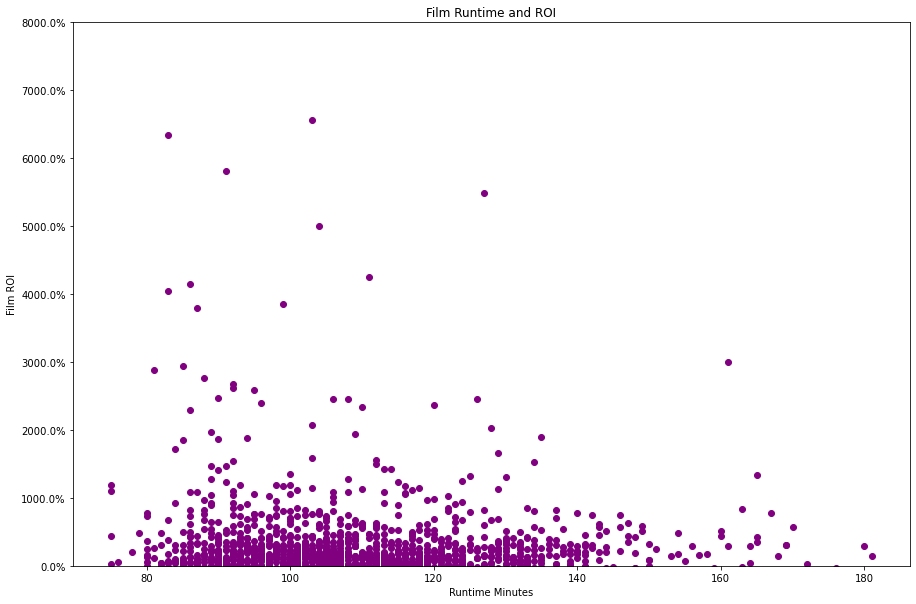

In [25]:
#film runtime and ROI data visualization
fig, ax =plt.subplots(figsize=(15,10))
ax.scatter(x=budgets_genres_df['runtime_minutes'], y=budgets_genres_df['ROI'], color= 'purple')
ax.set_title('Film Runtime and ROI')
ax.set_xlabel('Runtime Minutes')
ax.set_ylabel('Film ROI')
ax.set_ylim(-1,8000)
ax.yaxis.set_major_formatter('{x:1}%')

There is a slight negative correlation between runtime and ROI but they are not meaningfully related.

In [26]:
budgets_genres_df['runtime_minutes'].describe()

count    1687.000000
mean      106.363960
std        17.409596
min        75.000000
25%        93.000000
50%       104.000000
75%       116.000000
max       181.000000
Name: runtime_minutes, dtype: float64

Text(0.5, 1.0, 'Runtime Distribution')

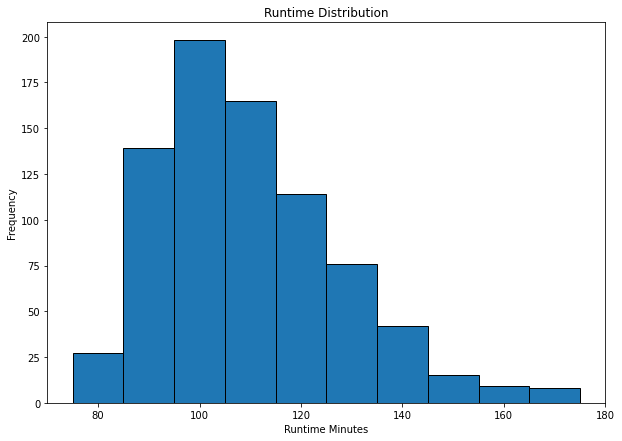

In [27]:
#Calculate the number of 'successes' (ROI =>100) in each bin
fig, ax= plt.subplots(figsize=(10,7))
df_double= budgets_genres_df[budgets_genres_df['ROI']>= 100]
ax.hist(x=df_double['runtime_minutes'], bins= 10, range=(75,175), edgecolor='black')
plt.xticks()
ax.set_xlabel('Runtime Minutes')
ax.set_ylabel('Frequency')
ax.set_title('Runtime Distribution')

Text(0.5, 1.0, 'Runtime Distribution')

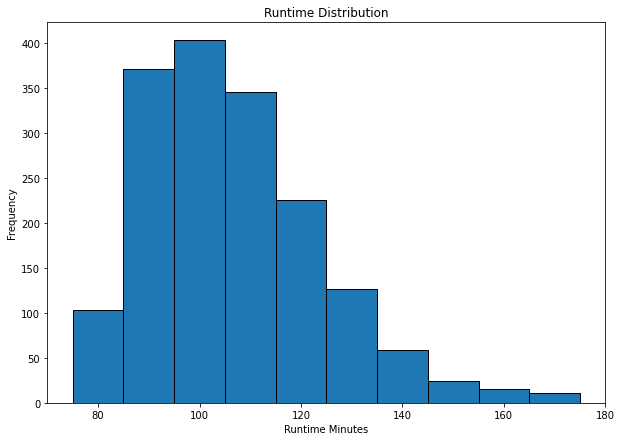

In [28]:
#Calculating the number of films in each bin
fig, ax= plt.subplots(figsize=(10,7))
ax.hist(x=budgets_genres_df['runtime_minutes'], bins= 10, range=(75,175), edgecolor='black')
plt.xticks()
ax.set_xlabel('Runtime Minutes')
ax.set_ylabel('Frequency')
ax.set_title('Runtime Distribution')

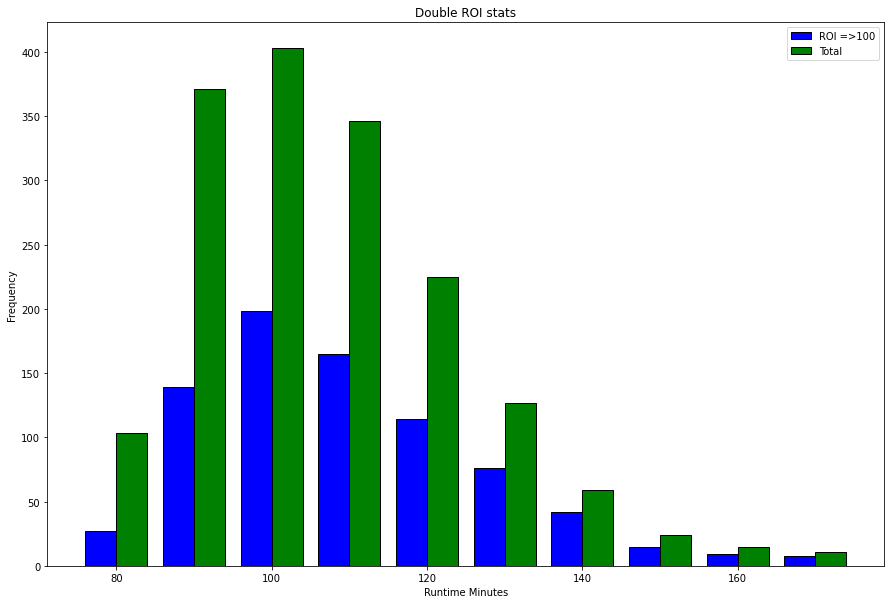

In [106]:
#Amount of 'successes' as compared with all entries 
y1=  df_double['runtime_minutes']
y2= budgets_genres_df['runtime_minutes']
colors= ['b','g']
labels= ['ROI =>100', 'Total']
fig, ax = plt.subplots(figsize=(15,10))
ax.hist([y1,y2], color= colors, label= labels, edgecolor= 'black', bins=10, range=(75,175))
ax.set_xlabel('Runtime Minutes')
ax.set_ylabel('Frequency')
ax.set_title('Double ROI stats')
ax.legend()

In [30]:
#Correlation Between Production budget and runtime
correlation1 = budgets_genres_df['runtime_minutes'].corr(budgets_genres_df['production_budget'])
correlation1

0.38535646755558123

## Evaluation: Runtime

There is meaningful correlation between runtime and production budget that suggests smaller budgets tend to have shorter runtimes. Films 95-105 minutes had the most total entries, and was also the bin that offered the most 100% ROI
(doubling their money) entries. As the runtime minutes goes up after 85 minutes, sample size goes down even though odds of a double tend to increase- likely due to having higher production budgets.

Runtime alone is likely not a key predictor for ROI and is dependent on production budget.

## Data Modeling: Genres

In [31]:
budgets_genres_df.sort_values(by='genres').head(60)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,ROI
924,52,2014,Blood Ties,26000000,42472,2923959,Blood Ties,Action,120.0,-88.754004
1288,79,2012,The Man with the Iron Fists,15000000,15634090,22018988,The Man with the Iron Fists,Action,95.0,46.793253
343,19,2016,The Little Prince,77500000,1311213,102028919,The Little Prince,Action,93.0,31.650218
2270,80,2014,Diamond Ruff,500000,0,0,Diamond Ruff,Action,82.0,-100.000000
1346,28,2016,Reign of Assassins,14000000,0,11354230,Reign of Assassins,"Action,Adventure",117.0,-18.898357
1818,54,2014,Falcon Rising,4500000,11774,11774,Falcon Rising,"Action,Adventure",103.0,-99.738356
480,22,2016,Kubo and the Two Strings,55000000,48023088,77548122,Kubo and the Two Strings,"Action,Adventure,Animation",101.0,40.996585
106,29,2014,Big Hero 6,165000000,222527828,652127828,Big Hero 6,"Action,Adventure,Animation",102.0,295.228987
35,44,2018,Incredibles 2,200000000,608581744,1242520711,Incredibles 2,"Action,Adventure,Animation",118.0,521.260356
876,100,2018,Bilal: A New Breed of Hero,30000000,490973,648599,Bilal: A New Breed of Hero,"Action,Adventure,Animation",105.0,-97.838003


In [32]:
df_double.tail(50)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,ROI
2023,41,2014,The Babadook,2000000,950792,7482387,The Babadook,"Drama,Horror",94.0,274.119350
2028,62,2015,Knock Knock,2000000,36336,6328516,Knock Knock,"Drama,Thriller",99.0,216.425800
2057,2,2010,Buried,1987650,1044143,21270290,Buried,Documentary,88.0,970.122506
2062,9,2011,Submarine,1900000,467602,4581937,Submarine,"Comedy,Drama,Romance",97.0,141.154579
2069,11,2013,ABCD (Any Body Can Dance),1900000,222098,10137234,ABCD (Any Body Can Dance),"Drama,Music",160.0,433.538632
2074,15,2010,The Last Exorcism,1800000,41034350,70165900,The Last Exorcism,"Drama,Horror,Thriller",87.0,3798.105556
2075,18,2012,Beasts of the Southern Wild,1800000,12795746,23265132,Beasts of the Southern Wild,"Adventure,Drama,Fantasy",93.0,1192.507333
2081,42,2014,The Lunchbox,1700000,4231500,12231500,The Lunchbox,"Drama,Romance",104.0,619.500000
2086,63,2011,Insidious,1500000,54009150,99870886,Insidious,"Horror,Mystery,Thriller",103.0,6558.059067
2087,64,2016,Moonlight,1500000,27854931,65245512,Moonlight,Drama,111.0,4249.700800


In [33]:
#Understanding genre breakdown
print(budgets_genres_df['genres'].value_counts())
print(df_double['genres'].value_counts())

Drama                           83
Adventure,Animation,Comedy      62
Comedy,Drama                    61
Comedy,Drama,Romance            61
Comedy                          59
                                ..
Action,Biography,Documentary     1
Adventure,Horror,Sci-Fi          1
Drama,History,Mystery            1
Adventure,Horror                 1
Adventure,Comedy,Sci-Fi          1
Name: genres, Length: 249, dtype: int64
Adventure,Animation,Comedy    45
Action,Adventure,Sci-Fi       42
Comedy,Drama,Romance          33
Comedy,Drama                  30
Drama                         30
                              ..
Comedy,Drama,Musical           1
Adventure,Crime,Drama          1
Romance,Sci-Fi,Thriller        1
Biography,Drama,Fantasy        1
Adventure,Comedy,Sci-Fi        1
Name: genres, Length: 161, dtype: int64


In [34]:
df_double.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,ROI
0,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Pirates of the Caribbean: On Stranger Tides,"Action,Adventure,Fantasy",136.0,154.667286
2,4,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,"Action,Adventure,Sci-Fi",141.0,324.384139
3,7,2018,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,"Action,Adventure,Sci-Fi",149.0,582.711400
4,9,2017,Justice League,300000000,229024295,655945209,Justice League,"Action,Adventure,Fantasy",120.0,118.648403
5,10,2015,Spectre,300000000,200074175,879620923,Spectre,"Action,Adventure,Thriller",148.0,193.206974


In [35]:
#How much each genre appears in the list of movies with 100% ROI
print(df_double['genres'].str.contains('Action').sum(),
df_double['genres'].str.contains('Adventure').sum(),
df_double['genres'].str.contains('Fantasy').sum(),
df_double['genres'].str.contains('Drama').sum(),
df_double['genres'].str.contains('Comedy').sum(),
df_double['genres'].str.contains('Sci-Fi').sum(),
df_double['genres'].str.contains('Horror').sum(),
df_double['genres'].str.contains('Romance').sum(),
df_double['genres'].str.contains('Animation').sum(),
df_double['genres'].str.contains('Mystery').sum(),
df_double['genres'].str.contains('Thriller').sum(),
df_double['genres'].str.contains('Crime').sum(),
df_double['genres'].str.contains('War').sum(),
df_double['genres'].str.contains('Western').sum(),
df_double['genres'].str.contains('Music').sum(),
df_double['genres'].str.contains('History').sum(),
df_double['genres'].str.contains('Biography').sum(),
df_double['genres'].str.contains('Documentary').sum(),
df_double['genres'].str.contains('Sports').sum())

244 222 65 355 294 92 100 108 68 79 138 97 6 2 31 18 64 18 0


In [36]:
#Remove secondary genres to emphasize primary genre in ROI 100 dataset
df_double['genres']= df_double['genres'].str.split(',').str[0]
df_double.head(50)

<ipython-input-36-2e8a248cd8e8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_double['genres']= df_double['genres'].str.split(',').str[0]


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,ROI
0,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Pirates of the Caribbean: On Stranger Tides,Action,136.0,154.667286
2,4,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,Action,141.0,324.384139
3,7,2018,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,Action,149.0,582.711400
4,9,2017,Justice League,300000000,229024295,655945209,Justice League,Action,120.0,118.648403
5,10,2015,Spectre,300000000,200074175,879620923,Spectre,Action,148.0,193.206974
6,11,2012,The Dark Knight Rises,275000000,448139099,1084439099,The Dark Knight Rises,Action,164.0,294.341491
10,15,2010,Tangled,260000000,200821936,586477240,Tangled,Adventure,100.0,125.568169
11,17,2016,Captain America: Civil War,250000000,408084349,1140069413,Captain America: Civil War,Action,147.0,356.027765
12,18,2016,Batman v Superman: Dawn of Justice,250000000,330360194,867500281,Batman v Superman: Dawn of Justice,Action,151.0,247.000112
13,19,2012,The Hobbit: An Unexpected Journey,250000000,303003568,1017003568,The Hobbit: An Unexpected Journey,Adventure,169.0,306.801427


In [37]:
#Remove secondary genres to emphasize primary genre in cumulative datset
budgets_genres_df['genres']= budgets_genres_df['genres'].str.split(',').str[0]
budgets_genres_df.head(50)

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,primary_title,genres,runtime_minutes,ROI
0,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,Pirates of the Caribbean: On Stranger Tides,Action,136.0,154.667286
1,3,2019,Dark Phoenix,350000000,42762350,149762350,Dark Phoenix,Action,113.0,-57.210757
2,4,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,Avengers: Age of Ultron,Action,141.0,324.384139
3,7,2018,Avengers: Infinity War,300000000,678815482,2048134200,Avengers: Infinity War,Action,149.0,582.711400
4,9,2017,Justice League,300000000,229024295,655945209,Justice League,Action,120.0,118.648403
5,10,2015,Spectre,300000000,200074175,879620923,Spectre,Action,148.0,193.206974
6,11,2012,The Dark Knight Rises,275000000,448139099,1084439099,The Dark Knight Rises,Action,164.0,294.341491
7,12,2018,Solo: A Star Wars Story,275000000,213767512,393151347,Solo: A Star Wars Story,Action,135.0,42.964126
8,13,2013,The Lone Ranger,275000000,89302115,260002115,The Lone Ranger,Action,150.0,-5.453776
9,14,2012,John Carter,275000000,73058679,282778100,John Carter,Action,132.0,2.828400


In [38]:
print(budgets_genres_df['genres'].value_counts('action'))
print(df_double['genres'].value_counts('action'))

Action         0.283343
Comedy         0.205691
Drama          0.177830
Adventure      0.099585
Biography      0.072318
Horror         0.058684
Crime          0.049200
Documentary    0.026082
Animation      0.006520
Thriller       0.005335
Family         0.003557
Mystery        0.002964
Fantasy        0.002964
Sci-Fi         0.002371
Romance        0.001186
Sport          0.000593
Western        0.000593
Music          0.000593
Musical        0.000593
Name: genres, dtype: float64
Action         0.306918
Comedy         0.207547
Drama          0.161006
Adventure      0.122013
Horror         0.069182
Biography      0.067925
Crime          0.032704
Documentary    0.013836
Animation      0.006289
Mystery        0.003774
Thriller       0.002516
Romance        0.002516
Fantasy        0.002516
Family         0.001258
Name: genres, dtype: float64


### Comparison of cumulative genre dataset with ROI 100 dataset
Action, adventure, and horror genres were the only three genres out of nineteen to see a material jump (more than 1%) in market share when the amongst all films that enjoyed at least a 100% ROI (doubled their money). 

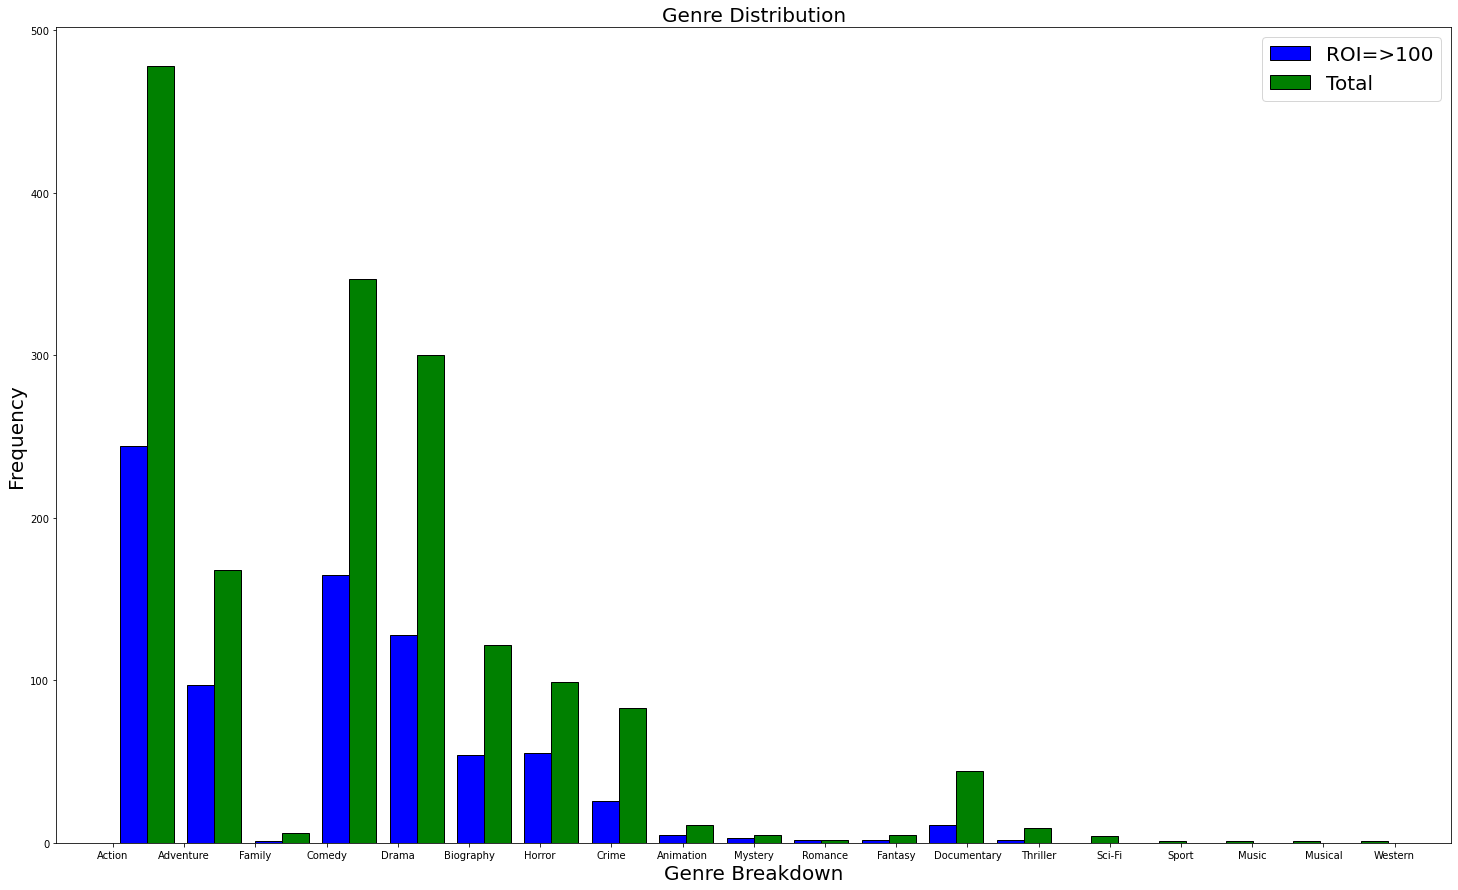

In [107]:
fig, ax= plt.subplots(figsize=(25,15))
a= df_double['genres']
b= budgets_genres_df['genres']
colors= ['b', 'g']
labels= ['ROI=>100', 'Total']
ax.hist([a,b], bins=19, color= colors, edgecolor='black', label= labels )
ax.set_xlabel('Genre Breakdown', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title('Genre Distribution', fontsize= 20)
ax.legend(fontsize= 20)


While the most common genres produced are action, comedy, and drama and it is these three genres that appear most in the 100% ROI dataset; it is the action, adventure, and horror genre films that gained the most market share off all the movies that returned double their investment. Action went from 28.3% to 30.7%, Adventure went from 10.0% to 12.2%, and Horror went from 5.9% to 6.9%.

In [41]:
#Checking the average ROI of each genre
budgets_genres_df.groupby('genres')['ROI'].mean()

genres
Action          161.603816
Adventure       206.547539
Animation       179.095483
Biography       221.905949
Comedy          188.280812
Crime            80.582147
Documentary      89.314064
Drama           249.796254
Family           59.241567
Fantasy         119.435807
Horror         1231.184085
Music           -49.539411
Musical         -90.503464
Mystery         193.364429
Romance         616.210393
Sci-Fi          -91.006700
Sport           -69.760511
Thriller         20.853374
Western        -100.000000
Name: ROI, dtype: float64

Text(0.5, 1.0, 'Average ROI by Genre')

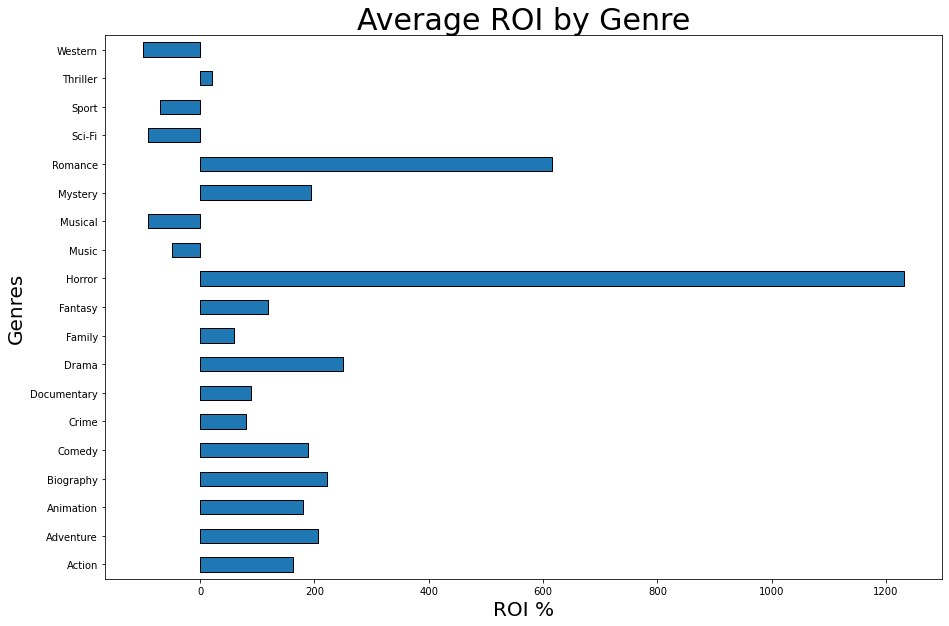

In [65]:
#Horror films have the highest average ROI by a significant margin
budgets_genres_df.groupby(['genres'])['ROI'].mean().plot(kind='barh', figsize=(15,10), edgecolor='black')
plt.xlabel('ROI %', fontsize=20)
plt.ylabel('Genres', fontsize=20)
plt.title('Average ROI by Genre', fontsize=30)



In [44]:
#Horror films have an average budget of $10.05M
budgets_genres_df.groupby('genres')['production_budget'].mean()

genres
Action         7.449464e+07
Adventure      7.328515e+07
Animation      4.172727e+07
Biography      2.277434e+07
Comedy         1.867091e+07
Crime          2.025422e+07
Documentary    1.260661e+07
Drama          1.593778e+07
Family         2.893333e+07
Fantasy        2.580000e+07
Horror         1.049058e+07
Music          1.800000e+07
Musical        5.600000e+06
Mystery        3.167000e+07
Romance        2.760000e+07
Sci-Fi         8.130000e+06
Sport          1.900000e+07
Thriller       1.031389e+07
Western        1.000000e+06
Name: production_budget, dtype: float64

In [45]:
#Average budget is $39.35M, almost 4x Horror average budgets.
budgets_genres_df['production_budget'].describe()

count    1.687000e+03
mean     3.934642e+07
std      5.380370e+07
min      1.400000e+03
25%      5.000000e+06
50%      1.950000e+07
75%      4.800000e+07
max      4.106000e+08
Name: production_budget, dtype: float64

In [46]:
#Average ROI of all genres is significantly below Horror genre.
budgets_genres_df['ROI'].describe()

count     1687.000000
mean       246.848007
std       1167.491655
min       -100.000000
25%        -65.378312
50%         80.550905
75%        278.572344
max      41556.474000
Name: ROI, dtype: float64

Text(0.5, 1.0, 'Average Production Budget by Genre')

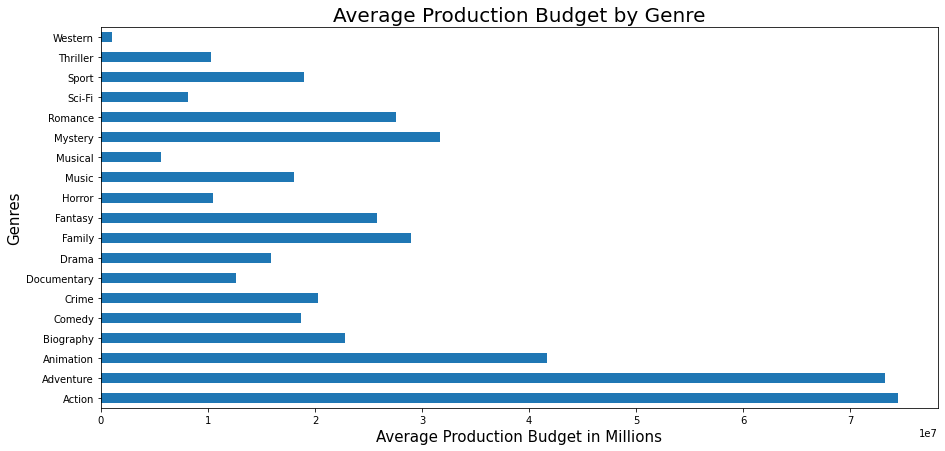

In [67]:
budgets_genres_df.groupby('genres')['production_budget'].mean().plot(kind= 'barh', figsize=(15,7))
plt.xlabel('Average Production Budget in Millions', fontsize=15)
plt.ylabel('Genres', fontsize=15)
plt.title('Average Production Budget by Genre', fontsize=20)

## Evaluation: Runtime

Perhaps the most overpowering statistic of them all, the average ROI of horror films is multitudes higher then the second best performing genre (Romance).  Although action and adventure films show greater representation along with horror in the 100% ROI dataset, it is the horror films that offer the most upside for producers by a significant margin.

Horror films also have amongst the lowest production budgets, which is likely a key contributor to their average ROI dominance but audiences definitely seem to have great demand for horror film independent of the size of their production budgets.

## Data Modeling and Cleaning: Production Budgets

In [68]:
movie_budgets.dtypes

id                    int64
release_date          int32
movie                object
production_budget    object
domestic_gross       object
worldwide_gross      object
dtype: object

In [69]:
#genre_budgets_df is substitued by ROI_df as runtime minutes and genre is not need for this analysis.
#Movies made before 2010 are now included
ROI_df=movie_budgets

In [70]:
#Drop $ to worldwide gross to convert to int
ROI_df['production_budget']= movie_budgets['production_budget'].map(lambda x: x[1:])
ROI_df['domestic_gross']= movie_budgets['domestic_gross'].map(lambda x: x[1:])
ROI_df['worldwide_gross']= movie_budgets['worldwide_gross'].map(lambda x: x[1:])
ROI_df


,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009,Avatar,"425,000,000","760,507,625","2,776,345,279"
1,2,2011,Pirates of the Caribbean: On Stranger Tides,"410,600,000","241,063,875","1,045,663,875"
2,3,2019,Dark Phoenix,"350,000,000","42,762,350","149,762,350"
3,4,2015,Avengers: Age of Ultron,"330,600,000","459,005,868","1,403,013,963"
4,5,2017,Star Wars Ep. VIII: The Last Jedi,"317,000,000","620,181,382","1,316,721,747"
...,...,...,...,...,...,...
5777,78,2018,Red 11,"7,000",0,0
5778,79,1999,Following,"6,000","48,482","240,495"
5779,80,2005,Return to the Land of Wonders,"5,000","1,338","1,338"
5780,81,2015,A Plague So Pleasant,"1,400",0,0


In [ ]:
#ROI_df['production_budget']= ROI_df['production_budget'].str.replace(',','').astype(int)
#ROI_df['domestic_gross']= ROI_df['domestic_gross'].str.replace(',','').astype(int)
#ROI_df['worldwide_gross']= ROI_df['worldwide_gross'].str.replace(',','').astype(int)


In [71]:
#Convert data type to int
ROI_df['production_budget']= ROI_df['production_budget'].str.replace(',','').astype(int)
ROI_df['domestic_gross']= ROI_df['domestic_gross'].str.replace(',','').astype(int)
ROI_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009,Avatar,425000000,760507625,"2,776,345,279"
1,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,"1,045,663,875"
2,3,2019,Dark Phoenix,350000000,42762350,"149,762,350"
3,4,2015,Avengers: Age of Ultron,330600000,459005868,"1,403,013,963"
4,5,2017,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,"1,316,721,747"
...,...,...,...,...,...,...
5777,78,2018,Red 11,7000,0,0
5778,79,1999,Following,6000,48482,"240,495"
5779,80,2005,Return to the Land of Wonders,5000,1338,"1,338"
5780,81,2015,A Plague So Pleasant,1400,0,0


In [72]:
ROI_df.dtypes

id                    int64
release_date          int32
movie                object
production_budget     int32
domestic_gross        int32
worldwide_gross      object
dtype: object

In [74]:
#convert data to int
import sys
ROI_df['worldwide_gross']= ROI_df['worldwide_gross'].astype('int64')

In [75]:
ROI_df.dtypes

id                    int64
release_date          int32
movie                object
production_budget     int32
domestic_gross        int32
worldwide_gross       int64
dtype: object

In [76]:
#Creating ROI column
ROI_df['ROI']= ((ROI_df['worldwide_gross'] / ROI_df['production_budget']-1)*100)
ROI_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,ROI
0,1,2009,Avatar,425000000,760507625,2776345279,553.257713
1,2,2011,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,154.667286
2,3,2019,Dark Phoenix,350000000,42762350,149762350,-57.210757
3,4,2015,Avengers: Age of Ultron,330600000,459005868,1403013963,324.384139
4,5,2017,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,315.369636
...,...,...,...,...,...,...,...
5777,78,2018,Red 11,7000,0,0,-100.000000
5778,79,1999,Following,6000,48482,240495,3908.250000
5779,80,2005,Return to the Land of Wonders,5000,1338,1338,-73.240000
5780,81,2015,A Plague So Pleasant,1400,0,0,-100.000000


In [77]:
ROI_df['production_budget'].describe()

count    5.782000e+03
mean     3.158776e+07
std      4.181208e+07
min      1.100000e+03
25%      5.000000e+06
50%      1.700000e+07
75%      4.000000e+07
max      4.250000e+08
Name: production_budget, dtype: float64

In [78]:
print(ROI_df.loc[ROI_df['production_budget']<= 5000000, 'ROI'].mean())
print(ROI_df.loc[ROI_df['production_budget']<= 5000000, 'ROI'].median())

896.9387294899469
-3.525900000000004


In [80]:
ROI_df= ROI_df.drop(ROI_df[ROI_df['production_budget']<= 500000].index)
#Below 500k budget would be unbefitting for Microsoft's brand.  Removing these entries also take out ROI outliers, adult films
# and film projects that had their budgets artificially deflated due to cast favors/deferrals. 

In [81]:
print(ROI_df.loc[ROI_df['production_budget']<= 5000000, 'ROI'].mean())
print(ROI_df.loc[ROI_df['production_budget']<= 5000000, 'ROI'].median())

500.26431033545634
10.055459999999993


In [ ]:
ROI_df.sort_values(by='ROI', ascending=False).tail(60)

In [82]:
#Average and Median definitions for each class of movie budget (low budget, mid-level budget, big budget, blockbuster budget)
avg_lb_ROI= ROI_df.loc[ROI_df['production_budget']<= 5000000, 'ROI'].mean()
med_lb_ROI= ROI_df.loc[ROI_df['production_budget']<= 5000000, 'ROI'].median()
avg_mb_ROI= ROI_df.loc[(ROI_df['production_budget']>= 5000000) & (ROI_df['production_budget']<= 50000000), 'ROI'].mean()
med_mb_ROI= ROI_df.loc[(ROI_df['production_budget']>= 5000000) & (ROI_df['production_budget']<= 50000000), 'ROI'].median()
avg_bb_ROI= ROI_df.loc[(ROI_df['production_budget']>= 50000000) & (ROI_df['production_budget']<= 100000000), 'ROI'].mean()
med_bb_ROI= ROI_df.loc[(ROI_df['production_budget']>= 50000000) & (ROI_df['production_budget']<100000000), 'ROI'].median()
avg_BBb_ROI= ROI_df.loc[ROI_df['production_budget']>= 100000000, 'ROI'].mean()
med_BBb_ROI= ROI_df.loc[ROI_df['production_budget']>= 100000000, 'ROI'].median()
print('Average ROI by tier:', avg_lb_ROI, avg_mb_ROI, avg_bb_ROI, avg_BBb_ROI)
print('Median ROI by tier:', med_lb_ROI, med_mb_ROI, med_bb_ROI, med_BBb_ROI)

Average ROI by tier: 500.26431033545634 210.84344666066235 154.66166089499376 208.90921347677798
Median ROI by tier: 10.055459999999993 67.15202333333335 95.5444762605042 175.0417226909091


In [84]:
#Creating the 4 tiered ROI dfs
lb_ROI=ROI_df[ROI_df['production_budget']<= 5000000]
mb_ROI=ROI_df[(ROI_df['production_budget']>= 5000000) & (ROI_df['production_budget']<= 50000000)]
bb_ROI= ROI_df[(ROI_df['production_budget']>= 50000000) & (ROI_df['production_budget']<= 100000000)]
BBb_ROI= ROI_df[ROI_df['production_budget']>= 100000000]

In [85]:
print(lb_ROI.describe())
print(mb_ROI.describe())
print(bb_ROI.describe())
print(BBb_ROI.describe())

                id  release_date  production_budget  domestic_gross  \
count  1181.000000   1181.000000       1.181000e+03    1.181000e+03   
mean     50.701101   2000.770533       2.663755e+06    8.758829e+06   
std      29.057417     18.436764       1.430094e+06    2.062460e+07   
min       1.000000   1925.000000       5.461730e+05    0.000000e+00   
25%      25.000000   1998.000000       1.300000e+06    1.299600e+04   
50%      51.000000   2007.000000       2.500000e+06    1.001437e+06   
75%      76.000000   2013.000000       4.000000e+06    8.025872e+06   
max     100.000000   2019.000000       5.000000e+06    2.414382e+08   

       worldwide_gross           ROI  
count     1.181000e+03   1181.000000  
mean      1.383053e+07    500.264310  
std       3.434881e+07   2071.798969  
min       0.000000e+00   -100.000000  
25%       7.124800e+04    -96.822250  
50%       2.419669e+06     10.055460  
75%       1.205192e+07    380.773200  
max       3.905252e+08  41283.333333  
         

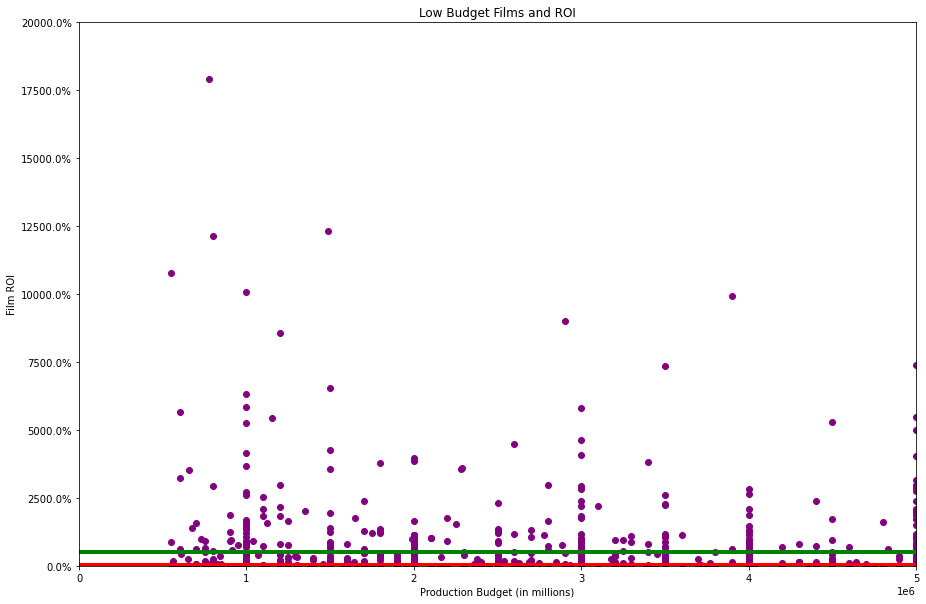

In [86]:
#Scatterplot showing relationship between low budget films ($.5M-$5M) and ROI
fig, ax =plt.subplots(figsize=(15,10))
ax.scatter(x=ROI_df['production_budget'], y=ROI_df['ROI'], color= 'purple',)
plt.axhline(y=avg_lb_ROI, color= 'green', linewidth=4)
plt.axhline(y=med_lb_ROI, color= 'red', linewidth=4)
ax.set_title('Low Budget Films and ROI')
ax.set_xlabel('Production Budget (in millions)')
ax.set_ylabel('Film ROI')
ax.set_xlim(0, 5000000)
ax.set_ylim(-1,20000)
ax.yaxis.set_major_formatter('{x:1}%')


In [87]:
#Correlation with low budget film's production budget and ROI
lb_ROI['production_budget'].corr(lb_ROI['ROI'])

-0.07293181822868648

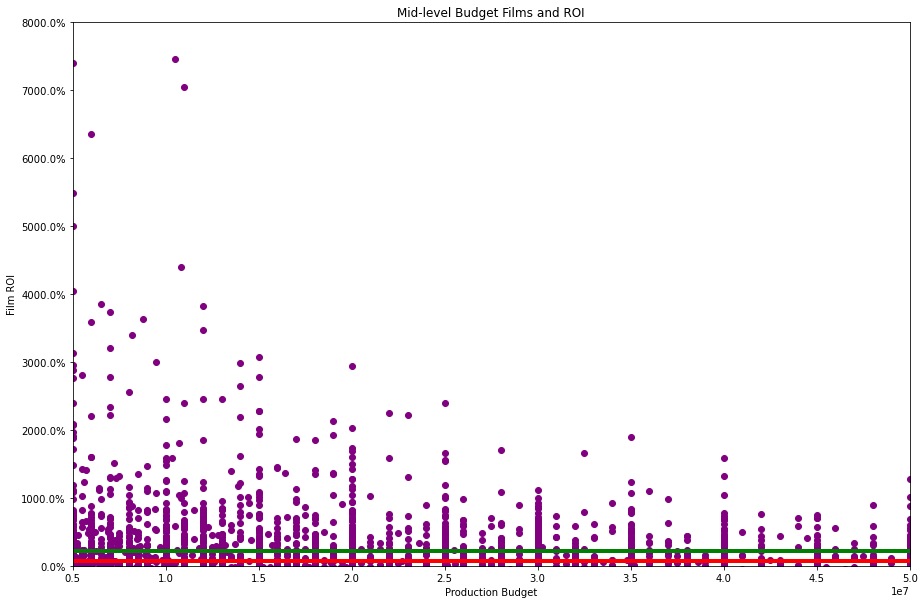

In [88]:
#Scatterplot showing relationship between mid-level budget films ($5M-$50M) and ROI
fig, ax =plt.subplots(figsize=(15,10))
ax.scatter(x=ROI_df['production_budget'], y=ROI_df['ROI'], color= 'purple')
plt.axhline(y=avg_mb_ROI, color= 'green', linewidth=4)
plt.axhline(y=med_mb_ROI, color= 'red', linewidth=4)
ax.set_title('Mid-level Budget Films and ROI')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Film ROI')
ax.set_xlim(5000000, 50000000)
ax.set_ylim(-1,8000)
ax.yaxis.set_major_formatter('{x:1}%')

In [89]:
#correlation with Mid-level produciton budgets and ROI
mb_ROI['production_budget'].corr(mb_ROI['ROI'])

-0.120005936296624

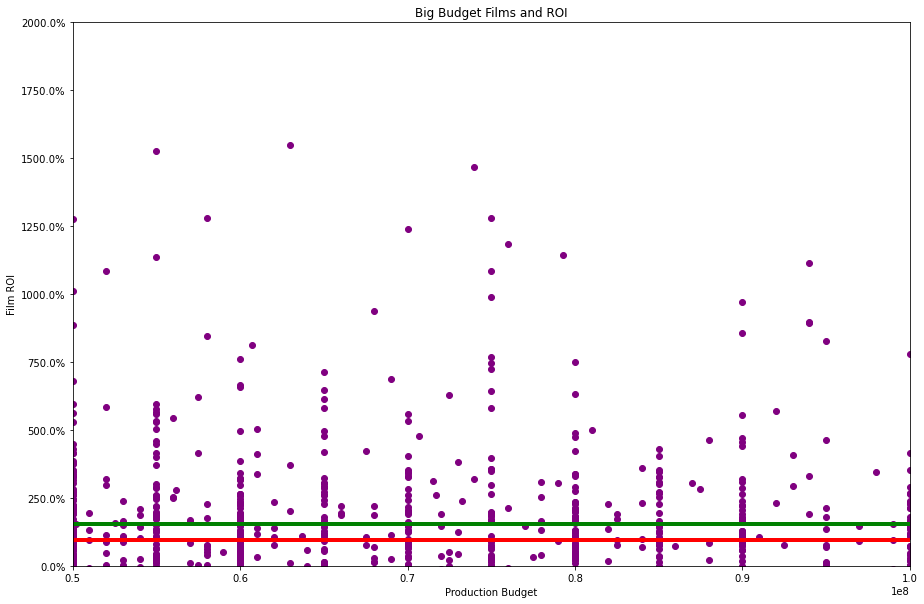

In [90]:
#Scatterplot showing relationship between big budget films ($50M-$100M) and ROI
fig, ax =plt.subplots(figsize=(15,10))
ax.scatter(x=ROI_df['production_budget'], y=ROI_df['ROI'], color= 'purple')
plt.axhline(y=avg_bb_ROI, color= 'green', linewidth=4)
plt.axhline(y=med_bb_ROI, color= 'red', linewidth=4)
ax.set_title('Big Budget Films and ROI')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Film ROI')
ax.set_xlim(50000000, 100000000)
ax.set_ylim(-1,2000)
ax.yaxis.set_major_formatter('{x:1}%')

In [91]:
#correlation with big produciton budgets and ROI
bb_ROI['production_budget'].corr(bb_ROI['ROI'])

0.04090902499936554

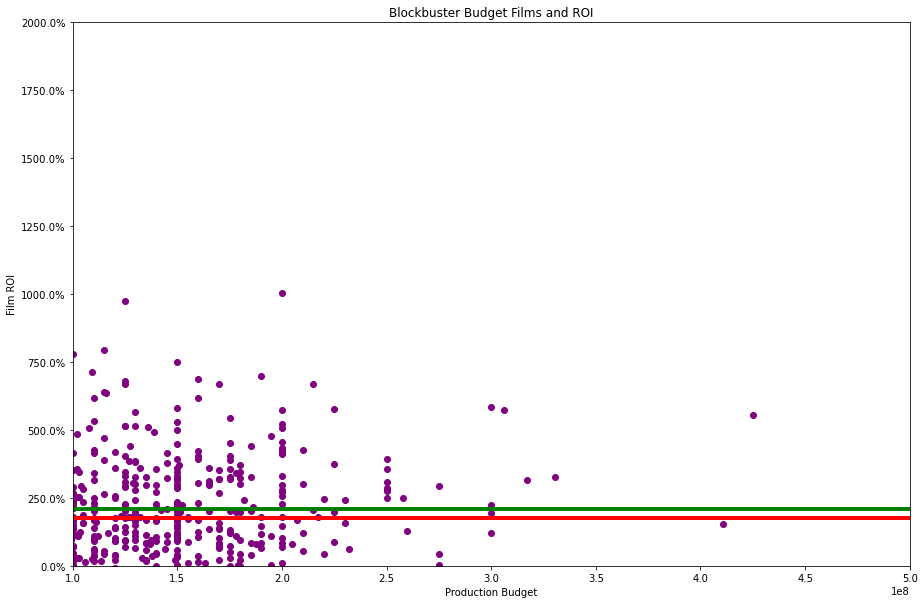

In [92]:
#Scatterplot showing relationship between blockbuster budget films ($100M-$500M) and ROI
fig, ax =plt.subplots(figsize=(15,10))
ax.scatter(x=ROI_df['production_budget'], y=ROI_df['ROI'], color= 'purple')
plt.axhline(y=avg_BBb_ROI, color= 'green', linewidth=4)
plt.axhline(y=med_BBb_ROI, color= 'red', linewidth=4)
ax.set_title('Blockbuster Budget Films and ROI')
ax.set_xlabel('Production Budget')
ax.set_ylabel('Film ROI')
ax.set_xlim(100000000, 500000000)
ax.set_ylim(-1,2000)
ax.yaxis.set_major_formatter('{x:1}%')

In [93]:
#correlation with Blockbuster produciton budgets and ROI
BBb_ROI['production_budget'].corr(BBb_ROI['ROI'])

0.1415115027281887

As production budget tiers get larger, so does its correlation with ROI.

In [94]:
#How does budget correlate with world-wide gross vs ROI
print(budgets_genres_df['production_budget'].corr(budgets_genres_df['worldwide_gross']))
print(budgets_genres_df['production_budget'].corr(budgets_genres_df['ROI']))

0.7910789831247879
-0.020878068027175862


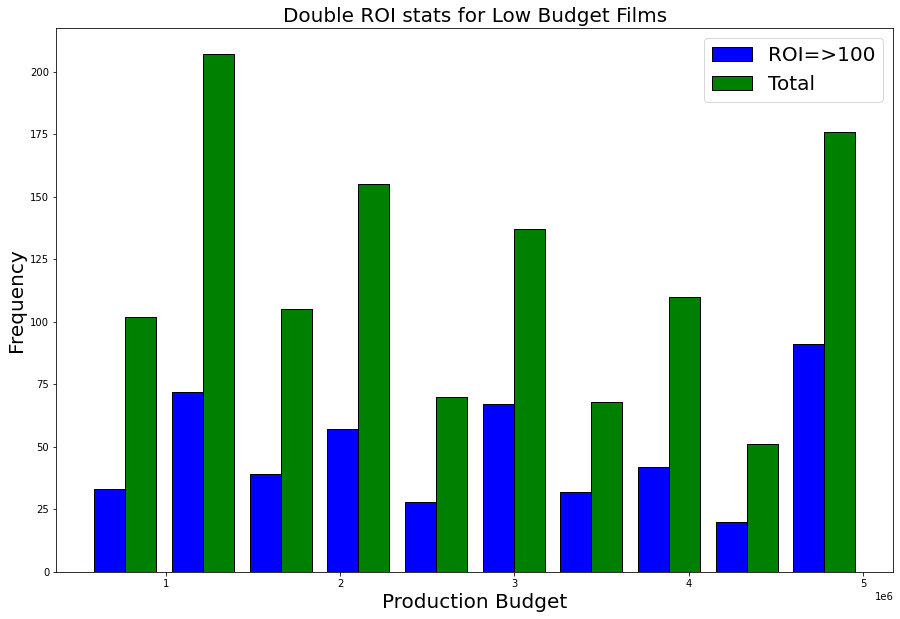

In [108]:
#How does low budget tier compare to its counterpart in ROI 100 df?
y3= lb_ROI[lb_ROI['ROI']>=100]['production_budget']
y4= lb_ROI['production_budget']
y5= mb_ROI[mb_ROI['ROI']>=100]['production_budget']
y6= mb_ROI['production_budget']
y7= bb_ROI[bb_ROI['ROI']>=100]['production_budget']
y8= bb_ROI['production_budget']
y9= BBb_ROI[BBb_ROI['ROI']>=100]['production_budget']
y10= BBb_ROI['production_budget']
colors= ['b','g']
labels= ['ROI=>100', 'Total']
fig, ax = plt.subplots(figsize=(15,10))
ax.hist([y3,y4], color= colors, label= labels, edgecolor= 'black')
plt.xticks()
ax.set_xlabel('Production Budget', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title('Double ROI stats for Low Budget Films', fontsize=20)
ax.legend(fontsize=20)

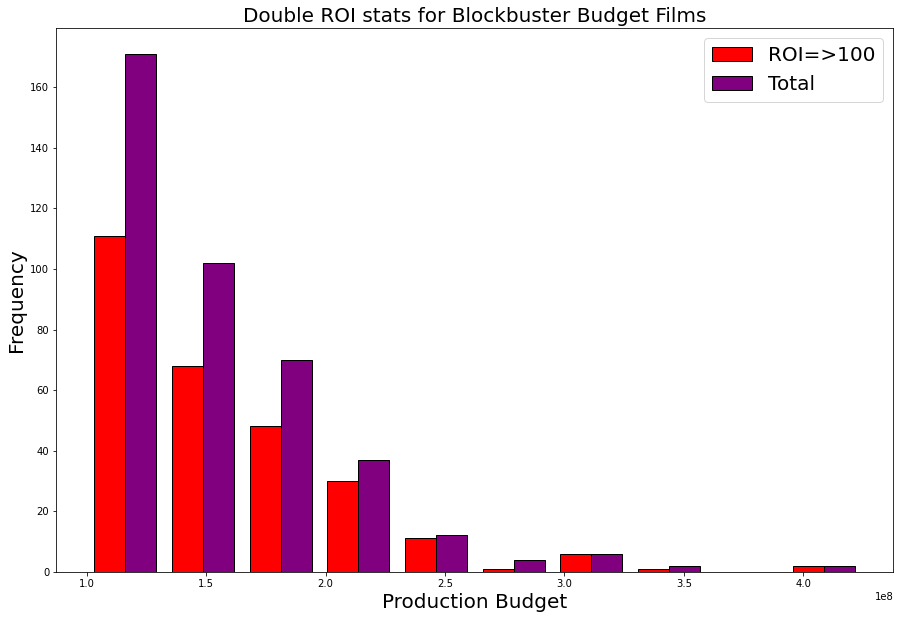

In [109]:
#How does Blockbuster budget compare to its counterpart in ROI 100 DF
colors= ['r','purple']
labels= ['ROI=>100', 'Total']
fig, ax = plt.subplots(figsize=(15,10))
ax.hist([y9,y10], color= colors, label= labels, edgecolor= 'black')
plt.xticks()
ax.set_xlabel('Production Budget', fontsize=20)
ax.set_ylabel('Frequency', fontsize=20)
ax.set_title('Double ROI stats for Blockbuster Budget Films', fontsize=20)
ax.legend(fontsize=20)

In [101]:
# Each tier's odds to achieve a 100% ROI or doubling of investment back.
print('Low Budget Movie odds of Double:', y3.count()/y4.count())
print('Mid-Level Budget Movie odds of Double:', y5.count()/y6.count())
print('Big Budget Movie odds of Double:', y7.count()/y8.count())
print('Blockbuster Budget Movie odds of Double:', y9.count()/y10.count())

Low Budget Movie odds of Double: 0.4072819644369179
Mid-Level Budget Movie odds of Double: 0.44471226272973785
Big Budget Movie odds of Double: 0.4911242603550296
Blockbuster Budget Movie odds of Double: 0.6847290640394089


In [102]:
print('Average ROI by tier:', avg_lb_ROI, avg_mb_ROI, avg_bb_ROI, avg_BBb_ROI)
print('Median ROI by tier:', med_lb_ROI, med_mb_ROI, med_bb_ROI, med_BBb_ROI)

Average ROI by tier: 500.26431033545634 210.84344666066235 154.66166089499376 208.90921347677798
Median ROI by tier: 10.055459999999993 67.15202333333335 95.5444762605042 175.0417226909091


## Evaluation: Production Budget
The lowest budget tier has the highest average ROI and lowest median ROI while the largest budger tier has the second lowest average ROI and highest median ROI.

Low budget movies are inherently riskier than larger movies as their median return is only 10% but they also tend to offer the largest upside as hits really skew the average ROI up.  The safest investment is the blockbuster budget tier where the average returns aren't the best but the median value is the highest suggesting less volatility and a safer floor.  Blockbuster tier movies also have the lowest ROI standard deviation while low budget films have the highest.

Blockbuster movies have a significantly higher chance to achieve a 100% ROI than all the other tiers. 68.5% of blockbuster tiered movies achieved a 100% ROI as compared to a 40.1% of low budget movies.

Despite the decreased volatility of blockbuster tier movies, the average ROI stat disparity cannot be ignored and Microsoft's business model would be best served producing a plethora of low budgets films and playings the odds for making a hit movie to maximize their investment return.

# Conclusion

Assuming the investment object for Microsoft is to start a movie studio that will produce a slate of movies (not just a single film), they should focus their investment to a specific niche of movies that will maximize ROI.  While there is a direct correlation between production budget and worldwide gross, it is the low budget movies ($.5M - $5m) that prove to be the most profitable by a significant margin.  The horror genre has a far higher average ROI than any other genre.  Film runtime is likely dependent on other variables such as genre and production budget and shouldn't be a factor in decision making

Low budget movies have the highest expected average return on investment.
Production budget has a large correlation to worldwide theatrical gross.
The horror genre shows the most resilieince to requiring a large production budget in order to get a sizeable theatrical gross.
Microsoft needs to focus on low budget horror films to maximize ROI.